# neural network（神经网络）

In [65]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import matplotlib
import scipy.optimize as opt
from sklearn.metrics import classification_report#这个包是评价报告

In [66]:
def load_data(path, transpose=True):
    data = sio.loadmat(path)
    y = data.get('y')  # (5000,1)
    y = y.reshape(y.shape[0])  # make it back to column vector

    X = data.get('X')  # (5000,400)

    if transpose:
        # for this dataset, you need a transpose to get the orientation right
        X = np.array([im.reshape((20, 20)).T for im in X])

        # and I flat the image again to preserve the vector presentation
        X = np.array([im.reshape(400) for im in X])

    return X, y

In [67]:
X, y = load_data('ex3data1.mat')

print(X.shape)
print(y.shape)

(5000, 400)
(5000,)


In [68]:
path='ex3data1.mat'
data = sio.loadmat(path)

In [69]:
def plot_an_image(image):
#     """
#     image : (400,)
#     """
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.matshow(image.reshape((20, 20)), cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))  # just get rid of ticks
    plt.yticks(np.array([]))
#绘图函数

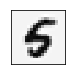

this should be 5


In [70]:
pick_one = np.random.randint(0, 5000)
plot_an_image(X[pick_one, :])
plt.show()
print('this should be {}'.format(y[pick_one]))

In [71]:
def plot_100_image(X):
    """ sample 100 image and show them
    assume the image is square

    X : (5000, 400)
    """
    size = int(np.sqrt(X.shape[1]))
    print("size=",size)

    # sample 100 image, reshape, reorg it
    sample_idx = np.random.choice(np.arange(X.shape[0]), 100)  # 100*400
    sample_images = X[sample_idx, :]

    fig, ax_array = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, figsize=(8, 8))

    for r in range(10):
        for c in range(10):
            ax_array[r, c].matshow(sample_images[10 * r + c].reshape((size, size)),
                                   cmap=matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))  
            #绘图函数，画100张图片

size= 20


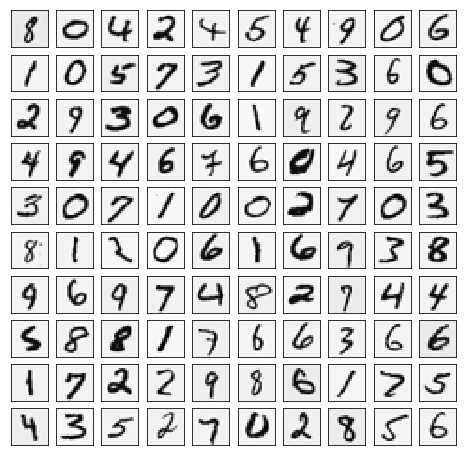

In [72]:
plot_100_image(X)
plt.show()

# 准备数据

In [73]:
raw_X, raw_y = load_data('ex3data1.mat')
print(raw_X.shape)
print(raw_y.shape)
print(raw_y)

(5000, 400)
(5000,)
[10 10 10 ...  9  9  9]


In [74]:
# add intercept=1 for x0
X = np.insert(raw_X, 0, values=np.ones(raw_X.shape[0]), axis=1)#插入了第一列（全部为1）
X.shape
print(type(X))

<class 'numpy.ndarray'>


元数据从1到10排列，这里转换成0～9

In [77]:
# y have 10 categories here. 1..10, they represent digit 0 as category 10 because matlab index start at 1
# I'll ditit 0, index 0 again
y_matrix = []

print(raw_y)
for k in range(1, 11):
    y_matrix.append((raw_y == k).astype(int))

print(len(y_matrix),len(y_matrix[0]))
# last one is k==10, it's digit 0, bring it to the first position，最后一列k=10，都是0，把最后一行放到第一行
y_matrix = [y_matrix[-1]] + y_matrix[:-1]
y = np.array(y_matrix)

y.shape

# 扩展 5000*1 到 5000*10
#     比如 y=10 -> [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]: ndarray
#     """

[10 10 10 ...  9  9  9]
10 5000


(10, 5000)

In [78]:
print(y)

[[1 1 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 1 1]]


# train 1 model（训练一维模型）

In [79]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [80]:
def cost(theta, X, y):
    ''' cost fn is -l(theta) for you to minimize'''
    return np.mean(-y * np.log(sigmoid(X @ theta)) - (1 - y) * np.log(1 - sigmoid(X @ theta)))


In [81]:
def regularized_cost(theta, X, y, l=1):
    '''you don't penalize theta_0'''
    theta_j1_to_n = theta[1:]
    regularized_term = (l / (2 * len(X))) * np.power(theta_j1_to_n, 2).sum()

    return cost(theta, X, y) + regularized_term

In [82]:
def gradient(theta, X, y):
    '''just 1 batch gradient'''
    return (1 / len(X)) * X.T @ (sigmoid(X @ theta) - y)


In [83]:
def regularized_gradient(theta, X, y, l=1):
    '''still, leave theta_0 alone'''
    theta_j1_to_n = theta[1:]
    regularized_theta = (l / len(X)) * theta_j1_to_n

    # by doing this, no offset is on theta_0
    regularized_term = np.concatenate([np.array([0]), regularized_theta])

    return gradient(theta, X, y) + regularized_term

In [84]:
def logistic_regression(X, y, l=1):
    """generalized logistic regression
    args:
        X: feature matrix, (m, n+1) # with incercept x0=1
        y: target vector, (m, )
        l: lambda constant for regularization

    return: trained parameters
    """
    # init theta
    theta = np.zeros(X.shape[1])

    # train it
    res = opt.minimize(fun=regularized_cost,
                       x0=theta,
                       args=(X, y, l),
                       method='TNC',
                       jac=regularized_gradient,
                       options={'disp': True})
    # get trained parameters
    final_theta = res.x

    return final_theta

In [85]:
def predict(x, theta):
    prob = sigmoid(x @ theta)
    #print(prob.shape,prob)
    print("prob.shape",prob.shape)
    return (prob >= 0.5).astype(int)


### 以y[1]为目标向量,训练参数用来检测输入向量是否为1

In [86]:
theta0 = logistic_regression(X, y[1])
#print(theta0)

In [88]:
print("theta0.shape:",theta0.shape)
print("X.shape:",X.shape)
y_pred = predict(X, theta0)
print("y_pred.shape",y_pred.shape)
print(y_pred)
print('Accuracy={}'.format(np.mean(y[1] == y_pred)))

theta0.shape: (401,)
X.shape: (5000, 401)
prob.shape (5000,)
y_pred.shape (5000,)
[0 0 0 ... 0 0 0]
Accuracy=0.9936


In [89]:
print('Accuracy={}'.format(np.mean(y[6] == y_pred)))

Accuracy=0.8016


# train k model（训练k维模型）

In [90]:
k_theta = np.array([logistic_regression(X, y[k]) for k in range(10)])
print(k_theta.shape)

(10, 401)


# 进行预测
* think about the shape of k_theta, now you are making $X\times\theta^T$
> $(5000, 401) \times (10, 401).T = (5000, 10)$
* after that, you run sigmoid to get probabilities and for each row, you find the highest prob as the answer

In [25]:
prob_matrix = sigmoid(X @ k_theta.T)

In [26]:
np.set_printoptions(suppress=True)
print("prob_matrix.shape:",prob_matrix.shape)

prob_matrix.shape: (5000, 10)


In [91]:
y_pred = np.argmax(prob_matrix, axis=1)#返回沿轴axis最大值的索引，axis=1代表行

In [92]:
#y_pred

In [93]:
y_answer = raw_y.copy()
y_answer[y_answer==10] = 0
print("y_answer.shape",y_answer.shape)

y_answer.shape (5000,)


### sklearn提供的函数, 统计分类准确率

In [94]:
print(classification_report(y_answer, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       500
           1       0.95      0.99      0.97       500
           2       0.95      0.92      0.93       500
           3       0.95      0.91      0.93       500
           4       0.95      0.95      0.95       500
           5       0.92      0.92      0.92       500
           6       0.97      0.98      0.97       500
           7       0.95      0.95      0.95       500
           8       0.93      0.92      0.92       500
           9       0.92      0.92      0.92       500

   micro avg       0.94      0.94      0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000



# 下面用神经网络来实现手写体数字分类

# 神经网络模型图示
<img style="float: left;" src="./nn_model.png">

## 加载训练好的参数

In [95]:
def load_weight(path):
    data = sio.loadmat(path)
    return data['Theta1'], data['Theta2']


In [96]:
theta1, theta2 = load_weight('ex3weights.mat')

theta1.shape, theta2.shape

((25, 401), (10, 26))

 因此在数据加载函数中，原始数据做了转置，然而，转置的数据与给定的参数不兼容，因为这些参数是由原始数据训练的。 所以为了应用给定的参数，我需要使用原始数据（不转置）

In [97]:
X, y = load_data('ex3data1.mat',transpose=False)

X = np.insert(X, 0, values=np.ones(X.shape[0]), axis=1)  # intercept

X.shape, y.shape

((5000, 401), (5000,))

# feed forward prediction（前馈预测）

In [98]:
a1 = X

## 计算第一层网络
$Z_2=X_1@\theta_{1}^T$

(5000, 401) @ (25,401).T = (5000, 25)
从第一层的400个特征，转换成第二层网络的25个特征

In [99]:
z2 = a1 @ theta1.T 
z2.shape

(5000, 25)

In [100]:
z2 = np.insert(z2, 0, values=np.ones(z2.shape[0]), axis=1) # 加入一个偏置特征

### 特征归一化

In [101]:
a2 = sigmoid(z2)
a2.shape

(5000, 26)

## 计算第二层网络
$Z_3=X_2@\theta_{2}^T$

(5000, 26) @ (26,10).T = (5000, 10)
从第一层的400个特征，转换成第二层网络的25个特征

In [102]:
z3 = a2 @ theta2.T
z3.shape

(5000, 10)

In [103]:
a3 = sigmoid(z3)
#a3

In [104]:
y_pred = np.argmax(a3, axis=1) + 1  # numpy is 0 base index, +1 for matlab convention，返回沿轴axis最大值的索引，axis=1代表行
y_pred.shape

(5000,)

# 准确率
 
虽然人工神经网络是非常强大的模型，但训练数据的准确性并不能完美预测实际数据，在这里很容易过拟合。

In [105]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           1       0.97      0.98      0.97       500
           2       0.98      0.97      0.97       500
           3       0.98      0.96      0.97       500
           4       0.97      0.97      0.97       500
           5       0.98      0.98      0.98       500
           6       0.97      0.99      0.98       500
           7       0.98      0.97      0.97       500
           8       0.98      0.98      0.98       500
           9       0.97      0.96      0.96       500
          10       0.98      0.99      0.99       500

   micro avg       0.98      0.98      0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000

